# ETTS Time-Series Forecasting with LMU

Train LMU model on Electricity Transformer Temperature (ETT) dataset.

In [2]:
from __future__ import annotations
from typing import Dict, Any
from pathlib import Path
import torch

# Import shared utilities
from src.notebooks.etts.utils import ETTSTask, make_block_cfg_ctor, evaluate_best_model

## Configuration

In [2]:
etth1_config  = {
    "batch": 64,
    "data_loader_kwargs": {
        "num_workers": 0,
        "which": "ETTh1",
        "seq_len": 96,
        "pred_len": 24,
        "feature_mode": "target",
        "target_col": "OT",
        "split_ratio": (0.7, 0.1, 0.2),
        "normalize": "zscore",
        "pin_memory": False,
        "persistent_workers": False,
    },
    "epochs": 50,
    "lr": 2e-4, # -> 1e-3,
    "wd": 1e-3, # -> 1e-4,
    "amp": True,
    "save_dir": "./runs/etts_task_h1",
    "warmup_epochs": 5,
    "patience": 10,
    "min_delta": 0.001,
    "d_model": 256,
    "depth": 6,
    "dropout": 0.5 ,# -> 0.2,
    "mlp_ratio": 2.0,
    "droppath_final": 0.2, # -> 0.1,
    "layerscale_init": 1e-2,
    "residual_gain": 1.0,
    "pool": "none",
}

etth2_config = {
    "batch": 64,
    "data_loader_kwargs": {
        "num_workers": 0,
        "which": "ETTh2",
        "seq_len": 96,
        "pred_len": 24,
        "feature_mode": "target",
        "target_col": "OT",
        "split_ratio": (0.7, 0.1, 0.2),
        "normalize": "zscore",
        "pin_memory": False,
        "persistent_workers": False,
    },
    "epochs": 50,
    "lr": 1e-4, # -> 1e-3,
    "wd": 2e-3, # -> 1e-4,
    "amp": True,
    "save_dir": "./runs/etts_task_h2",
    "warmup_epochs": 5,
    "patience": 10,
    "min_delta": 0.001,
    "d_model": 256,
    "depth": 4,
    "dropout": 0.55 ,# -> 0.2,
    "mlp_ratio": 2.0,
    "droppath_final": 0.3, # -> 0.1,
    "layerscale_init": 1e-2,
    "residual_gain": 1.0,
    "pool": "none",
}

ettm1_config = {
    "batch": 64,
    "data_loader_kwargs": {
        "num_workers": 0,
        "which": "ETTm1",
        "seq_len": 96,
        "pred_len": 24,
        "feature_mode": "target",
        "target_col": "OT",
        "split_ratio": (0.7, 0.1, 0.2),
        "normalize": "zscore",
        "pin_memory": False,
        "persistent_workers": False,
    },
    "epochs": 50,
    "lr": 1e-4, # -> 1e-3,
    "wd": 2e-3, # -> 1e-4,
    "amp": True,
    "save_dir": "./runs/etts_task_m1",
    "warmup_epochs": 5,
    "patience": 10,
    "min_delta": 0.001,
    "d_model": 256,
    "depth": 4,
    "dropout": 0.55 ,# -> 0.2,
    "mlp_ratio": 2.0,
    "droppath_final": 0.3, # -> 0.1,
    "layerscale_init": 1e-2,
    "residual_gain": 1.0,
    "pool": "none",
}


In [3]:
import torch
from pathlib import Path

current_dir = Path.cwd()
project_root = current_dir.parent.parent
data_root = str(project_root / "datasets" / "etts" / "data")

args = {
    "data_root": data_root,
    "batch": 64,
    "data_loader_kwargs": {
        "num_workers": 0,
        "which": "ETTm2",
        "seq_len": 96,
        "pred_len": 24,
        "feature_mode": "target",
        "target_col": "OT",
        "split_ratio": (0.7, 0.1, 0.2),
        "normalize": "zscore",
        "pin_memory": False,
        "persistent_workers": False,
    },
    "epochs": 50,
    "lr": 1e-4, # -> 1e-3,
    "wd": 2e-3, # -> 1e-4,
    "amp": True,
    "save_dir": "./runs/etts_task_m2",
    "warmup_epochs": 5,
    "patience": 10,
    "min_delta": 0.001,
    "d_model": 256,
    "depth": 4,
    "dropout": 0.55 ,# -> 0.2,
    "mlp_ratio": 2.0,
    "droppath_final": 0.3, # -> 0.1,
    "layerscale_init": 1e-2,
    "residual_gain": 1.0,
    "pool": "none",
}

args["block_cfg_ctor"] = make_block_cfg_ctor(
    kind="lmu",
    dropout=args["dropout"],
    mlp_ratio=args["mlp_ratio"],
    droppath_final=args["droppath_final"],
    layerscale_init=args["layerscale_init"],
    residual_gain=args["residual_gain"],
    pool=args["pool"],
)

if torch.backends.mps.is_available():
    args["device"] = torch.device("mps")
    print("Using MPS (M4 Neural Engine)")
elif torch.cuda.is_available():
    args["device"] = torch.device("cuda")
else:
    args["device"] = torch.device("cpu")
    args["amp"] = False

Using MPS (M4 Neural Engine)


## Training

In [4]:
from src.train_utils.trainer import Trainer
from src.models.v2.build_model import build_model
import os

# 1. Define the task
task = ETTSTask()

# 2. Set up MPS memory options if available
if args.get("device") and args["device"].type == "mps":
    torch.mps.set_per_process_memory_fraction(0.9)
    os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

trainer = Trainer(args=args, task=task, model_builder=build_model)

best_metric, best_path = trainer.fit()

history = trainer.history

print(f"\nTraining complete! Best validation {trainer.early_key}: {best_metric:.6f}")
print(f"Best model saved to: {best_path}")

/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: divide by zero encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: overflow encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: invalid value encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/li

💾 saved best model to ./runs/etts_task_m2/best.pt
✅ new best mse 2.2894
Epoch 000/50 | train 1.2424/1.2424 | val 2.2894/2.2894 | t 131.0s/3.9s | lr 1.00e-07


💾 saved best model to ./runs/etts_task_m2/best.pt
✅ new best mse 0.4466
Epoch 001/50 | train 0.3776/0.3776 | val 0.4466/0.4466 | t 86.0s/3.8s | lr 2.01e-05


💾 saved best model to ./runs/etts_task_m2/best.pt
✅ new best mse 0.1928
Epoch 002/50 | train 0.1563/0.1563 | val 0.1928/0.1928 | t 84.9s/3.5s | lr 4.01e-05


💾 saved best model to ./runs/etts_task_m2/best.pt
✅ new best mse 0.1815
Epoch 003/50 | train 0.1489/0.1489 | val 0.1815/0.1815 | t 86.9s/4.1s | lr 6.00e-05


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


💾 saved best model to ./runs/etts_task_m2/best.pt
✅ new best mse 0.1453
Epoch 004/50 | train 0.1358/0.1358 | val 0.1453/0.1453 | t 96.2s/4.0s | lr 8.00e-05


💾 saved best model to ./runs/etts_task_m2/best.pt
✅ new best mse 0.1046
Epoch 005/50 | train 0.1140/0.1140 | val 0.1046/0.1046 | t 96.5s/4.0s | lr 1.00e-04


💾 saved best model to ./runs/etts_task_m2/best.pt
✅ new best mse 0.0890
Epoch 006/50 | train 0.0995/0.0995 | val 0.0890/0.0890 | t 101.1s/4.2s | lr 9.99e-05


💾 saved best model to ./runs/etts_task_m2/best.pt
✅ new best mse 0.0867
Epoch 007/50 | train 0.0884/0.0884 | val 0.0867/0.0867 | t 101.5s/4.3s | lr 9.95e-05


Epoch 008/50 | train 0.0783/0.0783 | val 0.0981/0.0981 | t 102.5s/4.3s | lr 9.89e-05


Epoch 009/50 | train 0.0697/0.0697 | val 0.0861/0.0861 | t 112.0s/4.6s | lr 9.81e-05


Epoch 010/50 | train 0.0622/0.0622 | val 0.0945/0.0945 | t 117.1s/4.6s | lr 9.70e-05


Epoch 011/50 | train 0.0560/0.0560 | val 0.1132/0.1132 | t 119.2s/5.5s | lr 9.57e-05


Epoch 012/50 | train 0.0510/0.0510 | val 0.1081/0.1081 | t 116.9s/5.1s | lr 9.41e-05


Epoch 013/50 | train 0.0471/0.0471 | val 0.2427/0.2427 | t 111.4s/4.6s | lr 9.24e-05


Epoch 014/50 | train 0.0446/0.0446 | val 0.1638/0.1638 | t 119.1s/4.8s | lr 9.05e-05


Epoch 015/50 | train 0.0420/0.0420 | val 0.2097/0.2097 | t 117.9s/4.8s | lr 8.83e-05


Epoch 016/50 | train 0.0403/0.0403 | val 0.2819/0.2819 | t 116.3s/4.8s | lr 8.60e-05


Epoch 017/50 | train 0.0386/0.0386 | val 0.1794/0.1794 | t 123.2s/5.2s | lr 8.35e-05


⏹ Early stopping (patience=10, best=0.0867).
📊 Training history saved to ./runs/etts_task_m2/history.json

Training complete! Best validation mse: 0.086741
Best model saved to: ./runs/etts_task_m2/best.pt


## Plot History

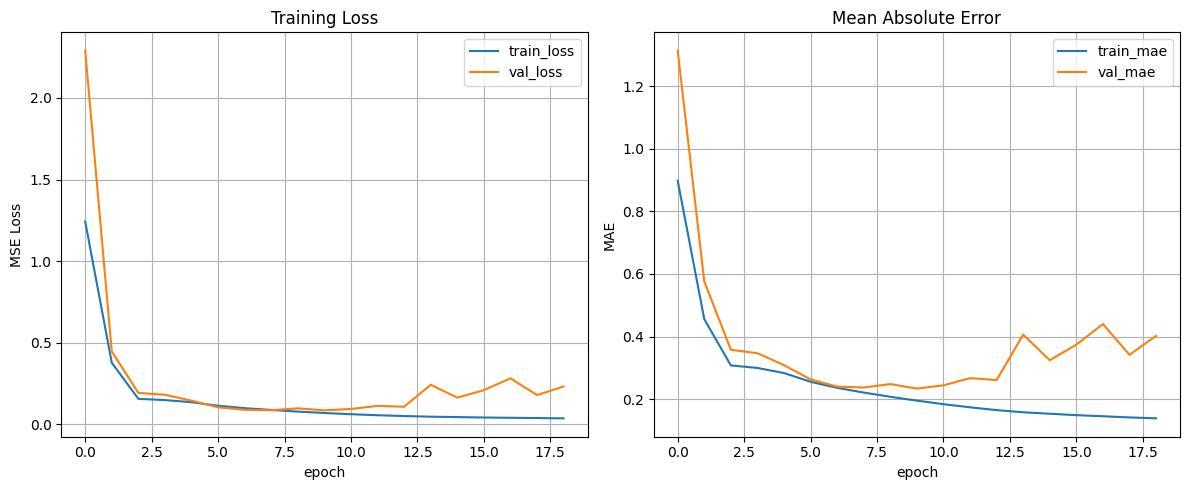

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_mae"], label="train_mae")
plt.plot(history["val_mae"], label="val_mae")
plt.xlabel("epoch")
plt.ylabel("MAE")
plt.legend()
plt.title("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()

## Test Evaluation

In [6]:
from src.models.v2.build_model import build_model

preds, targets = evaluate_best_model(
    args=args,
    task=task,
    model_builder=build_model,
    best_model_path=best_path
)

Evaluating best model on the test set...


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: divide by zero encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: overflow encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: invalid value encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/li

Loaded checkpoint from epoch 7
Validation MSE: 0.086741, Validation MAE: 0.237160


Testing:   0%|          | 0/216 [00:00<?, ?it/s]


TEST SET RESULTS:
MSE:  0.168420
MAE:  0.325869
RMSE: 0.410390
